# Crypto Portfolio Selection 

In [1]:
import jax.numpy as jnp
import polars as pl
import polars.selectors as cs

In [2]:
import pandas as pd
import yfinance as yf

data: pd.DataFrame = yf.download("BTC-USD ETH-USD", start="2022-01-01", end="2024-01-01")["Close"].dropna()

[*********************100%***********************]  2 of 2 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

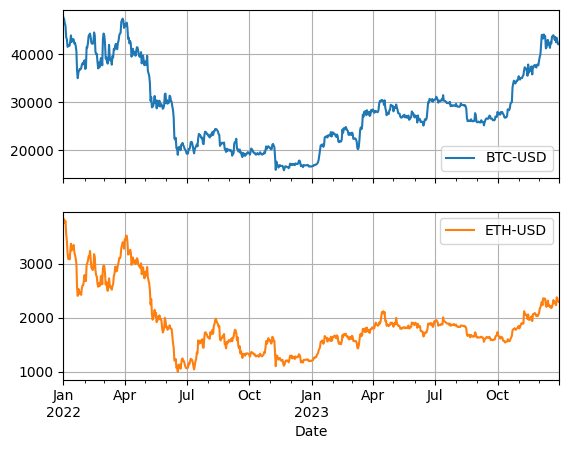

In [3]:
data.plot(grid=True, subplots=True)

In [4]:
df_returns = (
    pl.from_dataframe(data.reset_index()) 
    .select(
        cs.datetime(),
        pl.col("BTC-USD").pct_change(),
        pl.col("ETH-USD").pct_change(),
    )
)
df_returns

Date,BTC-USD,ETH-USD
"datetime[ns, UTC]",f64,f64
2022-01-01 00:00:00 UTC,null,null
2022-01-02 00:00:00 UTC,-0.007163,0.015881
2022-01-03 00:00:00 UTC,-0.018737,-0.017805
2022-01-04 00:00:00 UTC,-0.012066,0.008687
2022-01-05 00:00:00 UTC,-0.050734,-0.064224
…,…,…
2023-12-27 00:00:00 UTC,0.021694,0.065999
2023-12-28 00:00:00 UTC,-0.01876,-0.013105
2023-12-29 00:00:00 UTC,-0.012397,-0.019968


# Offline portfolio

In [5]:
from pyfoliopt.benchmark import best_kelly_portfolio


returns = jnp.array(
    df_returns.to_numpy()[1:, 1:]
)

long_only = best_kelly_portfolio(returns)
long_short = best_kelly_portfolio(returns, short_selling=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


<Axes: xlabel='Date'>

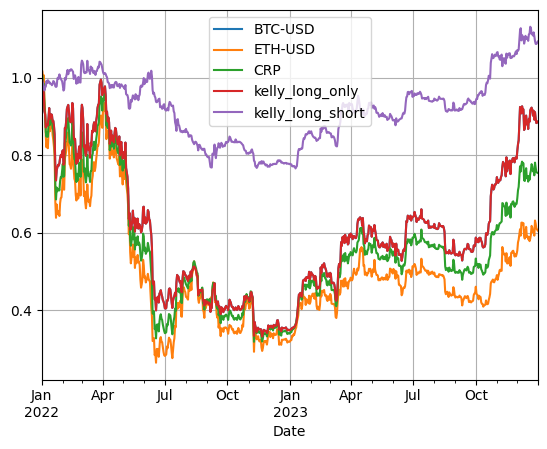

In [6]:
(
    df_returns
    .with_columns(
        CRP = pl.col("BTC-USD") * 0.5 + pl.col("ETH-USD") * 0.5,
        kelly_long_only = pl.col("BTC-USD") * long_only[0] + pl.col("ETH-USD") * long_only[1],
        kelly_long_short = pl.col("BTC-USD") * long_short[0] + pl.col("ETH-USD") * long_short[1],
    )
    .select(cs.datetime(), cs.numeric().add(1).cum_prod())
    .to_pandas()
    .set_index("Date")
    .plot(grid=True)
)

# Online portfolio

## Long/short portfolio

In [ ]:
from pyfoliopt.optimizer import proj_gd
from pyfoliopt.projection import projection_l1_ball
from pyfoliopt.loss import neg_logdot_loss
